<a href="https://www.kaggle.com/code/arjunsingh711/art-work-classification-using-vgg-and-cam-visualiz?scriptVersionId=137629244" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Classic data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import PIL
from sklearn.model_selection import train_test_split

# tensorflow libaries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, VGG19
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import tqdm
import warnings
import glob
import os

# Metrics
from sklearn import metrics
import itertools

# WANDB 
import wandb
wandb.login()

# Noteboook setting
%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
dataset = '/kaggle/input/best-artworks-of-all-time/images/images'

In [3]:
art_types=os.listdir(dataset)
art_types
len(art_types)

51

In [4]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

# print(labels)

In [5]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels,name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels],axis=1)
image_df

,Filepath,Label
0,/kaggle/input/best-artworks-of-all-time/images...,Jackson_Pollock
1,/kaggle/input/best-artworks-of-all-time/images...,Jackson_Pollock
2,/kaggle/input/best-artworks-of-all-time/images...,Jackson_Pollock
3,/kaggle/input/best-artworks-of-all-time/images...,Jackson_Pollock
4,/kaggle/input/best-artworks-of-all-time/images...,Jackson_Pollock
...,...,...
8769,/kaggle/input/best-artworks-of-all-time/images...,Pieter_Bruegel
8770,/kaggle/input/best-artworks-of-all-time/images...,Pieter_Bruegel
8771,/kaggle/input/best-artworks-of-all-time/images...,Pieter_Bruegel
8772,/kaggle/input/best-artworks-of-all-time/images...,Pieter_Bruegel


In [6]:
image_df['Label'].value_counts(ascending=False)

Vincent_van_Gogh             877
Edgar_Degas                  702
Pablo_Picasso                439
Pierre-Auguste_Renoir        336
Albrecht_Du╠êrer             328
Albrecht_Dürer              328
Paul_Gauguin                 311
Francisco_Goya               291
Rembrandt                    262
Alfred_Sisley                259
Titian                       255
Marc_Chagall                 239
Rene_Magritte                194
Amedeo_Modigliani            193
Paul_Klee                    188
Henri_Matisse                186
Andy_Warhol                  181
Mikhail_Vrubel               171
Sandro_Botticelli            164
Leonardo_da_Vinci            143
Peter_Paul_Rubens            141
Salvador_Dali                139
Hieronymus_Bosch             137
Pieter_Bruegel               134
Diego_Velazquez              128
Kazimir_Malevich             126
Frida_Kahlo                  120
Giotto_di_Bondone            119
Gustav_Klimt                 117
Raphael                      109
Joan_Miro 

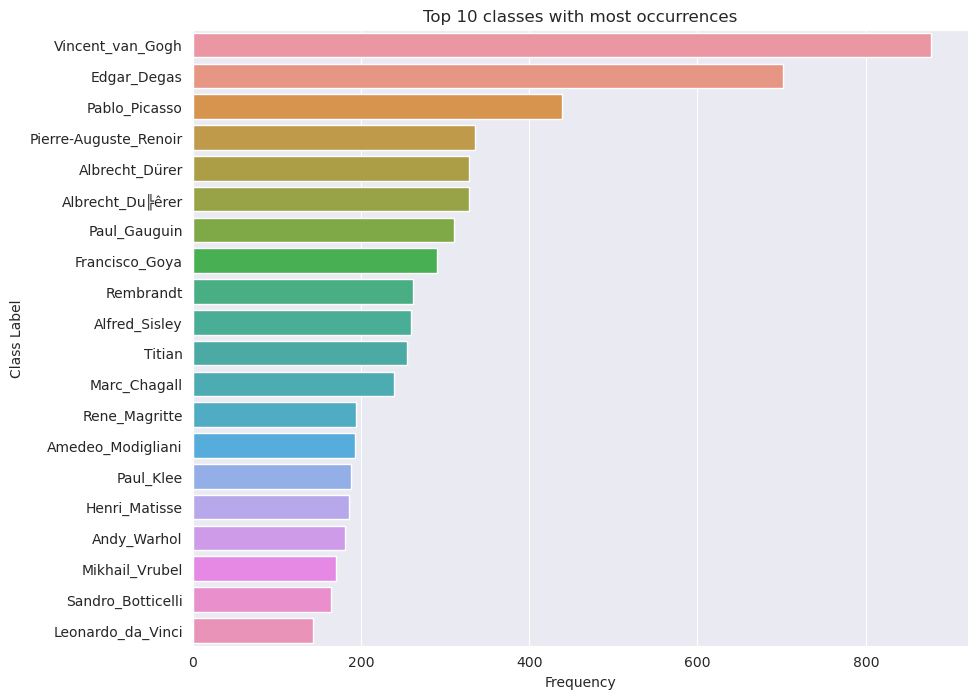

In [7]:
class_freq = {}
class_labels = image_df['Label']
for label in class_labels:
    if label in class_freq:
        class_freq[label] +=1
    else:
        class_freq[label] = 1
        
# sort the classes by frequency in descending order
sorted_class = sorted(class_freq.items(),key=lambda x: x[1],reverse=True)
# print(sorted_class)
top_classes = dict(sorted_class[:20])

plt.figure(figsize=(10,8))
sns.countplot(y=class_labels, order=top_classes.keys())
plt.xlabel("Frequency")
plt.ylabel("Class Label")
plt.title("Top 10 classes with most occurrences")
plt.show();

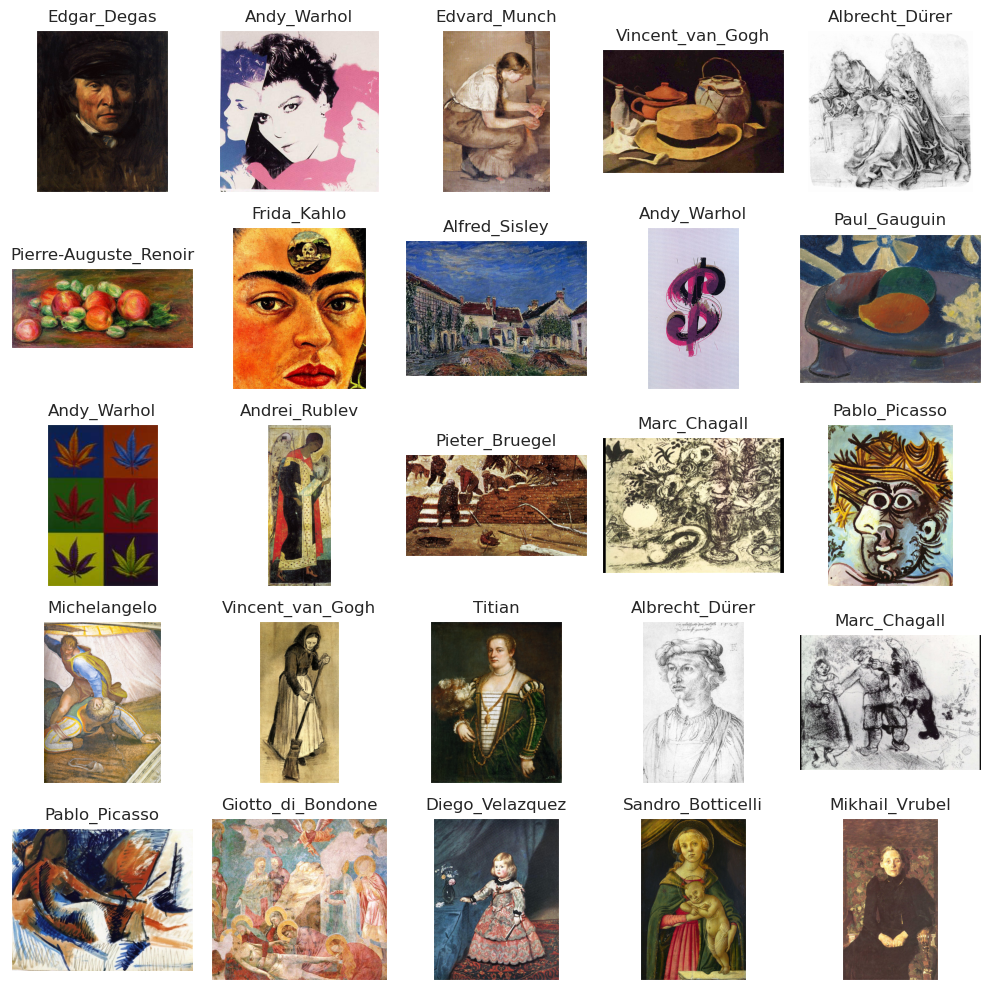

56

In [8]:
random_index = np.random.randint(0,len(image_df),25)
fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10),
                        subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show();
56

## Data Preprocssing

In [9]:
train_df, test_df = train_test_split(image_df, test_size=0.2,
                                     shuffle=True,random_state=42)

In [10]:
# train_gen = ImageDataGenerator(
#     rotation_range = 15,
#     width_shift_range = 0.05,
#     height_shift_range = 0.05,
#     rescale = 1./255,
#     shear_range = 0.05,
#     brightness_range = [0.1,1.5],
#     horizontal_flip = True,
#     vertical_flip = True
# )

train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
# Split the data into three categories
train_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5616 validated image filenames belonging to 51 classes.
Found 1403 validated image filenames belonging to 51 classes.
Found 1755 validated image filenames belonging to 51 classes.


In [12]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

        
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    
    model = Model(input_image, [yolo_82])    
    return model

In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
inputs = base_model.input
x = resize_and_rescale(inputs)
x = Dense(51, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(51,activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(51,activation='softmax')(x)

model =  Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [16]:
from wandb.keras import WandbCallback
run = wandb.init(project='art-museums-classification',
                config={ # include hyperparameters and metadata
                    "learning_rate":0.0001,
                    "epochs":100,
                    "batch_size":32,
                    "es_patience":8,
                    "loss_function":"categorical_crossentropy",
                    
                })
config = wandb.config # we will use this to configure our experiment
tf.keras.backend.clear_session()

# model callbacks, optimizers and compilation

## Optimizer
optimizer = tf.keras.optimizers.Adam(config.learning_rate)

## Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=config.es_patience,
                              restore_best_weights=True)
# Create checkpoint callback
checkpoint_path = "art_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Model compile
model.compile(optimizer,config.loss_function,metrics=['accuracy'])

wandb: Currently logged in as: arjun-jt11d. Use `wandb login --relogin` to force relogin


In [ ]:
history = model.fit(
    train_images, 
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=config.epochs,
    callbacks=[
        early_stopping,
        WandbCallback(),
        checkpoint_callback,
    ]
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
176/176 [==============================] - ETA: 0s - loss: 3.8541 - accuracy: 0.0575

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 213s 1s/step - loss: 3.8541 - accuracy: 0.0575 - val_loss: 3.6892 - val_accuracy: 0.0991
Epoch 2/100
176/176 [==============================] - ETA: 0s - loss: 3.6340 - accuracy: 0.1090

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 787ms/step - loss: 3.6340 - accuracy: 0.1090 - val_loss: 3.5008 - val_accuracy: 0.1475
Epoch 3/100
176/176 [==============================] - ETA: 0s - loss: 3.4695 - accuracy: 0.1446

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 780ms/step - loss: 3.4695 - accuracy: 0.1446 - val_loss: 3.3157 - val_accuracy: 0.1946
Epoch 4/100
176/176 [==============================] - ETA: 0s - loss: 3.3062 - accuracy: 0.1772

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 155s 883ms/step - loss: 3.3062 - accuracy: 0.1772 - val_loss: 3.1653 - val_accuracy: 0.2259
Epoch 5/100
176/176 [==============================] - ETA: 0s - loss: 3.1687 - accuracy: 0.2053

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 776ms/step - loss: 3.1687 - accuracy: 0.2053 - val_loss: 3.0236 - val_accuracy: 0.2530
Epoch 6/100
176/176 [==============================] - ETA: 0s - loss: 3.0420 - accuracy: 0.2366

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 780ms/step - loss: 3.0420 - accuracy: 0.2366 - val_loss: 2.9163 - val_accuracy: 0.2794
Epoch 7/100
176/176 [==============================] - ETA: 0s - loss: 2.9412 - accuracy: 0.2482

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 789ms/step - loss: 2.9412 - accuracy: 0.2482 - val_loss: 2.8029 - val_accuracy: 0.3043
Epoch 8/100
176/176 [==============================] - ETA: 0s - loss: 2.8412 - accuracy: 0.2749

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 780ms/step - loss: 2.8412 - accuracy: 0.2749 - val_loss: 2.6901 - val_accuracy: 0.3172
Epoch 9/100
176/176 [==============================] - ETA: 0s - loss: 2.7251 - accuracy: 0.2977

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 777ms/step - loss: 2.7251 - accuracy: 0.2977 - val_loss: 2.5989 - val_accuracy: 0.3464
Epoch 10/100
176/176 [==============================] - ETA: 0s - loss: 2.6466 - accuracy: 0.3137

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 778ms/step - loss: 2.6466 - accuracy: 0.3137 - val_loss: 2.5129 - val_accuracy: 0.3585
Epoch 11/100
176/176 [==============================] - ETA: 0s - loss: 2.5558 - accuracy: 0.3333

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 778ms/step - loss: 2.5558 - accuracy: 0.3333 - val_loss: 2.4291 - val_accuracy: 0.3792
Epoch 12/100
176/176 [==============================] - ETA: 0s - loss: 2.4938 - accuracy: 0.3417

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 780ms/step - loss: 2.4938 - accuracy: 0.3417 - val_loss: 2.3831 - val_accuracy: 0.3920
Epoch 13/100
176/176 [==============================] - ETA: 0s - loss: 2.4090 - accuracy: 0.3666

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 782ms/step - loss: 2.4090 - accuracy: 0.3666 - val_loss: 2.3040 - val_accuracy: 0.3991
Epoch 14/100
176/176 [==============================] - ETA: 0s - loss: 2.3597 - accuracy: 0.3709

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 783ms/step - loss: 2.3597 - accuracy: 0.3709 - val_loss: 2.2536 - val_accuracy: 0.4070
Epoch 15/100
176/176 [==============================] - ETA: 0s - loss: 2.2912 - accuracy: 0.3802

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 792ms/step - loss: 2.2912 - accuracy: 0.3802 - val_loss: 2.2016 - val_accuracy: 0.4155
Epoch 16/100
176/176 [==============================] - ETA: 0s - loss: 2.2429 - accuracy: 0.4037

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 786ms/step - loss: 2.2429 - accuracy: 0.4037 - val_loss: 2.1705 - val_accuracy: 0.4191
Epoch 17/100
176/176 [==============================] - ETA: 0s - loss: 2.1983 - accuracy: 0.4012

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 783ms/step - loss: 2.1983 - accuracy: 0.4012 - val_loss: 2.1230 - val_accuracy: 0.4262
Epoch 18/100
176/176 [==============================] - ETA: 0s - loss: 2.1594 - accuracy: 0.4154

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 790ms/step - loss: 2.1594 - accuracy: 0.4154 - val_loss: 2.0918 - val_accuracy: 0.4391
Epoch 19/100
176/176 [==============================] - ETA: 0s - loss: 2.1090 - accuracy: 0.4257

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 776ms/step - loss: 2.1090 - accuracy: 0.4257 - val_loss: 2.0577 - val_accuracy: 0.4391
Epoch 20/100
176/176 [==============================] - ETA: 0s - loss: 2.0732 - accuracy: 0.4316

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 787ms/step - loss: 2.0732 - accuracy: 0.4316 - val_loss: 2.0219 - val_accuracy: 0.4419
Epoch 21/100
176/176 [==============================] - ETA: 0s - loss: 2.0348 - accuracy: 0.4432

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 786ms/step - loss: 2.0348 - accuracy: 0.4432 - val_loss: 2.0008 - val_accuracy: 0.4576
Epoch 22/100
176/176 [==============================] - ETA: 0s - loss: 1.9752 - accuracy: 0.4590

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 136s 774ms/step - loss: 1.9752 - accuracy: 0.4590 - val_loss: 1.9749 - val_accuracy: 0.4576
Epoch 23/100
176/176 [==============================] - ETA: 0s - loss: 1.9650 - accuracy: 0.4519

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 140s 798ms/step - loss: 1.9650 - accuracy: 0.4519 - val_loss: 1.9516 - val_accuracy: 0.4604
Epoch 24/100
176/176 [==============================] - ETA: 0s - loss: 1.8993 - accuracy: 0.4729

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 781ms/step - loss: 1.8993 - accuracy: 0.4729 - val_loss: 1.9226 - val_accuracy: 0.4647
Epoch 25/100
176/176 [==============================] - ETA: 0s - loss: 1.8763 - accuracy: 0.4726

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 781ms/step - loss: 1.8763 - accuracy: 0.4726 - val_loss: 1.9050 - val_accuracy: 0.4661
Epoch 26/100
176/176 [==============================] - ETA: 0s - loss: 1.8570 - accuracy: 0.4795

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 140s 795ms/step - loss: 1.8570 - accuracy: 0.4795 - val_loss: 1.8863 - val_accuracy: 0.4661
Epoch 27/100
176/176 [==============================] - ETA: 0s - loss: 1.8202 - accuracy: 0.4847

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 783ms/step - loss: 1.8202 - accuracy: 0.4847 - val_loss: 1.8712 - val_accuracy: 0.4726
Epoch 28/100
176/176 [==============================] - ETA: 0s - loss: 1.7709 - accuracy: 0.5030

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 787ms/step - loss: 1.7709 - accuracy: 0.5030 - val_loss: 1.8344 - val_accuracy: 0.4875
Epoch 29/100
176/176 [==============================] - 120s 681ms/step - loss: 1.7857 - accuracy: 0.4952 - val_loss: 1.8357 - val_accuracy: 0.4811
Epoch 30/100
176/176 [==============================] - ETA: 0s - loss: 1.7464 - accuracy: 0.5023

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 136s 771ms/step - loss: 1.7464 - accuracy: 0.5023 - val_loss: 1.8212 - val_accuracy: 0.4775
Epoch 31/100
176/176 [==============================] - ETA: 0s - loss: 1.7316 - accuracy: 0.4982

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 779ms/step - loss: 1.7316 - accuracy: 0.4982 - val_loss: 1.8125 - val_accuracy: 0.4854
Epoch 32/100
176/176 [==============================] - ETA: 0s - loss: 1.6786 - accuracy: 0.5205

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 782ms/step - loss: 1.6786 - accuracy: 0.5205 - val_loss: 1.7966 - val_accuracy: 0.4840
Epoch 33/100
176/176 [==============================] - ETA: 0s - loss: 1.6476 - accuracy: 0.5278

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 154s 878ms/step - loss: 1.6476 - accuracy: 0.5278 - val_loss: 1.7848 - val_accuracy: 0.4911
Epoch 34/100
176/176 [==============================] - ETA: 0s - loss: 1.6491 - accuracy: 0.5297

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 136s 775ms/step - loss: 1.6491 - accuracy: 0.5297 - val_loss: 1.7711 - val_accuracy: 0.4911
Epoch 35/100
176/176 [==============================] - ETA: 0s - loss: 1.6297 - accuracy: 0.5304

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 779ms/step - loss: 1.6297 - accuracy: 0.5304 - val_loss: 1.7655 - val_accuracy: 0.4954
Epoch 36/100
176/176 [==============================] - ETA: 0s - loss: 1.5985 - accuracy: 0.5377

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 785ms/step - loss: 1.5985 - accuracy: 0.5377 - val_loss: 1.7432 - val_accuracy: 0.5039
Epoch 37/100
176/176 [==============================] - ETA: 0s - loss: 1.5633 - accuracy: 0.5570

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 788ms/step - loss: 1.5633 - accuracy: 0.5570 - val_loss: 1.7333 - val_accuracy: 0.5011
Epoch 38/100
176/176 [==============================] - ETA: 0s - loss: 1.5627 - accuracy: 0.5447

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 141s 804ms/step - loss: 1.5627 - accuracy: 0.5447 - val_loss: 1.7332 - val_accuracy: 0.5046
Epoch 39/100
176/176 [==============================] - ETA: 0s - loss: 1.5350 - accuracy: 0.5564

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 792ms/step - loss: 1.5350 - accuracy: 0.5564 - val_loss: 1.7263 - val_accuracy: 0.5004
Epoch 40/100
176/176 [==============================] - ETA: 0s - loss: 1.5205 - accuracy: 0.5559

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 141s 799ms/step - loss: 1.5205 - accuracy: 0.5559 - val_loss: 1.7165 - val_accuracy: 0.5025
Epoch 41/100
176/176 [==============================] - ETA: 0s - loss: 1.4954 - accuracy: 0.5671

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 141s 801ms/step - loss: 1.4954 - accuracy: 0.5671 - val_loss: 1.7065 - val_accuracy: 0.5082
Epoch 42/100
176/176 [==============================] - ETA: 0s - loss: 1.4682 - accuracy: 0.5686

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 793ms/step - loss: 1.4682 - accuracy: 0.5686 - val_loss: 1.6988 - val_accuracy: 0.5061
Epoch 43/100
176/176 [==============================] - 120s 684ms/step - loss: 1.4777 - accuracy: 0.5712 - val_loss: 1.6999 - val_accuracy: 0.5032
Epoch 44/100
176/176 [==============================] - ETA: 0s - loss: 1.4299 - accuracy: 0.5743

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 790ms/step - loss: 1.4299 - accuracy: 0.5743 - val_loss: 1.6979 - val_accuracy: 0.5075
Epoch 45/100
176/176 [==============================] - ETA: 0s - loss: 1.4348 - accuracy: 0.5759

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 790ms/step - loss: 1.4348 - accuracy: 0.5759 - val_loss: 1.6812 - val_accuracy: 0.5082
Epoch 46/100
176/176 [==============================] - ETA: 0s - loss: 1.4021 - accuracy: 0.5819

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 141s 803ms/step - loss: 1.4021 - accuracy: 0.5819 - val_loss: 1.6764 - val_accuracy: 0.5132
Epoch 47/100
176/176 [==============================] - 120s 680ms/step - loss: 1.3898 - accuracy: 0.5833 - val_loss: 1.6766 - val_accuracy: 0.5096
Epoch 48/100
176/176 [==============================] - ETA: 0s - loss: 1.3665 - accuracy: 0.6002

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 140s 793ms/step - loss: 1.3665 - accuracy: 0.6002 - val_loss: 1.6756 - val_accuracy: 0.5118
Epoch 49/100
176/176 [==============================] - ETA: 0s - loss: 1.3438 - accuracy: 0.5976

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 790ms/step - loss: 1.3438 - accuracy: 0.5976 - val_loss: 1.6657 - val_accuracy: 0.5110
Epoch 50/100
176/176 [==============================] - ETA: 0s - loss: 1.3514 - accuracy: 0.6038

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 791ms/step - loss: 1.3514 - accuracy: 0.6038 - val_loss: 1.6549 - val_accuracy: 0.5175
Epoch 51/100
176/176 [==============================] - ETA: 0s - loss: 1.3400 - accuracy: 0.5995

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 783ms/step - loss: 1.3400 - accuracy: 0.5995 - val_loss: 1.6534 - val_accuracy: 0.5146
Epoch 52/100
176/176 [==============================] - ETA: 0s - loss: 1.3046 - accuracy: 0.6141

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 139s 792ms/step - loss: 1.3046 - accuracy: 0.6141 - val_loss: 1.6528 - val_accuracy: 0.5189
Epoch 53/100
176/176 [==============================] - 122s 690ms/step - loss: 1.3089 - accuracy: 0.6120 - val_loss: 1.6530 - val_accuracy: 0.5125
Epoch 54/100
176/176 [==============================] - 121s 685ms/step - loss: 1.2712 - accuracy: 0.6168 - val_loss: 1.6569 - val_accuracy: 0.5110
Epoch 55/100
176/176 [==============================] - ETA: 0s - loss: 1.2578 - accuracy: 0.6245

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 138s 786ms/step - loss: 1.2578 - accuracy: 0.6245 - val_loss: 1.6405 - val_accuracy: 0.5225
Epoch 56/100
176/176 [==============================] - 122s 694ms/step - loss: 1.2572 - accuracy: 0.6241 - val_loss: 1.6421 - val_accuracy: 0.5182
Epoch 57/100
176/176 [==============================] - ETA: 0s - loss: 1.2428 - accuracy: 0.6296

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 779ms/step - loss: 1.2428 - accuracy: 0.6296 - val_loss: 1.6343 - val_accuracy: 0.5182
Epoch 58/100
176/176 [==============================] - ETA: 0s - loss: 1.2169 - accuracy: 0.6384

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 154s 876ms/step - loss: 1.2169 - accuracy: 0.6384 - val_loss: 1.6326 - val_accuracy: 0.5210
Epoch 59/100
176/176 [==============================] - 120s 680ms/step - loss: 1.1987 - accuracy: 0.6378 - val_loss: 1.6421 - val_accuracy: 0.5203
Epoch 60/100
176/176 [==============================] - 120s 681ms/step - loss: 1.1674 - accuracy: 0.6473 - val_loss: 1.6336 - val_accuracy: 0.5175
Epoch 61/100
176/176 [==============================] - ETA: 0s - loss: 1.1620 - accuracy: 0.6496

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230412_233614-zq1l24r9/files/model-best)... Done. 0.1s


176/176 [==============================] - 137s 778ms/step - loss: 1.1620 - accuracy: 0.6496 - val_loss: 1.6265 - val_accuracy: 0.5232
Epoch 62/100
176/176 [==============================] - 120s 682ms/step - loss: 1.1608 - accuracy: 0.6476 - val_loss: 1.6291 - val_accuracy: 0.5217
Epoch 63/100
169/176 [===========================>..] - ETA: 3s - loss: 1.1706 - accuracy: 0.6454

In [ ]:
def plot_loss_accuracy_curves(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show();
    
plot_loss_accuracy_curves(history)

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
pred

In [ ]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Result
print(f'First 5 predictions: {pred[:5]}')

In [ ]:
random_index = np.random.randint(0,len(test_df)-1,25)
fig, axes = plt.subplots(nrows=5, ncols=5,figsize=(25,15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}",
                color=color)

plt.show()
plt.tight_layout()

In [ ]:
5